In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SalaryPrediction').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/06 13:46:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Datasets/salary1.csv', inferSchema=True, header=True)

In [3]:
df.printSchema()
df.count()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



32561

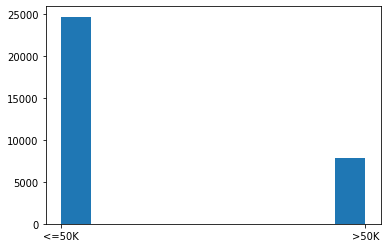

<=50K: 24720
>50K: 7841


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
incomeArr = np.array(df.select('income').collect())
plt.hist(incomeArr)
plt.show()
print("<=50K: "+str(df.filter(df['income'] == '<=50K').count()))
print(">50K: "+str(df.filter(df['income'] == '>50K').count()))

In [5]:
from pyspark.sql.functions import col,isnan, when, count
df.select('age').orderBy('age', ascending=False).show(1)
df.select('age').orderBy('age').show(1)
ageWithIncome = df.select("*",when(df['age'] <=20, '0-20')
          .when((df['age'] >20) & (df['age'] <= 40), '21-40')
          .when((df['age'] >40) & (df['age'] <= 60), '41-60')
          .when((df['age'] >60) & (df['age'] <= 80), '61-80')
          .otherwise('80+').alias('age_range')).groupBy("income","age_range").count().orderBy('age_range','income').show()


+---+
|age|
+---+
| 90|
+---+
only showing top 1 row

+---+
|age|
+---+
| 17|
+---+
only showing top 1 row

+------+---------+-----+
|income|age_range|count|
+------+---------+-----+
| <=50K|     0-20| 2408|
|  >50K|     0-20|    2|
| <=50K|    21-40|13622|
|  >50K|    21-40| 3086|
| <=50K|    41-60| 6909|
|  >50K|    41-60| 4202|
| <=50K|    61-80| 1696|
|  >50K|    61-80|  537|
| <=50K|      80+|   85|
|  >50K|      80+|   14|
+------+---------+-----+



In [6]:
df.groupBy("income","education-num").count().orderBy('education-num','income', ascending=False).show(40)


+------+-------------+-----+
|income|education-num|count|
+------+-------------+-----+
|  >50K|           16|  306|
| <=50K|           16|  107|
|  >50K|           15|  423|
| <=50K|           15|  153|
|  >50K|           14|  959|
| <=50K|           14|  764|
|  >50K|           13| 2221|
| <=50K|           13| 3134|
|  >50K|           12|  265|
| <=50K|           12|  802|
|  >50K|           11|  361|
| <=50K|           11| 1021|
|  >50K|           10| 1387|
| <=50K|           10| 5904|
|  >50K|            9| 1675|
| <=50K|            9| 8826|
|  >50K|            8|   33|
| <=50K|            8|  400|
|  >50K|            7|   60|
| <=50K|            7| 1115|
|  >50K|            6|   62|
| <=50K|            6|  871|
|  >50K|            5|   27|
| <=50K|            5|  487|
|  >50K|            4|   40|
| <=50K|            4|  606|
|  >50K|            3|   16|
| <=50K|            3|  317|
|  >50K|            2|    6|
| <=50K|            2|  162|
| <=50K|            1|   51|
+------+------

In [7]:
df.select('hours-per-week').orderBy('hours-per-week', ascending=False).show(1)
df.select('hours-per-week').orderBy('hours-per-week').show(1)
hoursWithIncome = df.select("*",when(df['hours-per-week'] <=20, '0-20')
          .when((df['hours-per-week'] >20) & (df['hours-per-week'] <= 40), '21-40')
          .when((df['hours-per-week'] >40) & (df['hours-per-week'] <= 60), '41-60')
          .when((df['hours-per-week'] >60) & (df['hours-per-week'] <= 80), '61-80')
          .otherwise('80+').alias('hours_range')).groupBy("income","hours_range").count().orderBy('hours_range','income').show()


+--------------+
|hours-per-week|
+--------------+
|            99|
+--------------+
only showing top 1 row

+--------------+
|hours-per-week|
+--------------+
|             1|
+--------------+
only showing top 1 row

+------+-----------+-----+
|income|hours_range|count|
+------+-----------+-----+
| <=50K|       0-20| 2733|
|  >50K|       0-20|  195|
| <=50K|      21-40|16262|
|  >50K|      21-40| 3790|
| <=50K|      41-60| 5019|
|  >50K|      41-60| 3452|
| <=50K|      61-80|  561|
|  >50K|      61-80|  341|
| <=50K|        80+|  145|
|  >50K|        80+|   63|
+------+-----------+-----+



In [32]:
non_string_cols = [c for c, t in df.dtypes if t !='string']
bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
    )
    # numeric columns
    for c in non_string_cols
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
outliers=df.select(
    "*",
    *[
        when(
            col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in non_string_cols
    ]
).select('age_out','fnlwgt_out','education-num_out','capital-gain_out','capital-loss_out','hours-per-week_out')
outliers.groupBy().sum().collect()

[Row(sum(age_out)=143, sum(fnlwgt_out)=992, sum(education-num_out)=1198, sum(capital-gain_out)=2712, sum(capital-loss_out)=1519, sum(hours-per-week_out)=9008)]